In [1]:
import pandas as pd
import numpy as np

In [2]:
from dateutil import parser
from datetime import datetime
import sys, os
import re
import optuna
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RepeatedKFold, KFold, ShuffleSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
optuna.logging.set_verbosity(optuna.logging.WARNING)
from Stacking_model import BoostedHybrid
import time

In [3]:
#9. read resources 
data = pd.read_csv('data.csv',
                  parse_dates=['date'],
                  infer_datetime_format=True,
                  index_col = 0)

#### `Exclude skus with zero and nearly zero consumption`

In [4]:
#del outliers (but exclude holidays)
data = data.loc[(data.outliers != -1) | (data.holiday == 1)]

In [5]:
data.drop('outliers', axis=1, inplace=True)

In [6]:
#let's find skus without any consumption and exclude them from the dataset
dg = data.groupby('sku')['sales_1'].sum()
sku_0 = dg.loc[dg == 0].index

In [7]:
len(sku_0)

59

In [8]:
dg2 = data.groupby(['year', 'month', 'sku'])['MA_30'].sum().reset_index()

In [9]:
#sksu with zero consumption in 2017
sku_1 = dg2.loc[(dg2.year == 2017) &\
                    (dg2.month == 8) &\
                        (dg2.MA_30 == 0), 'sku'].unique()

In [10]:
len(sku_1)

100

<AxesSubplot:xlabel='date'>

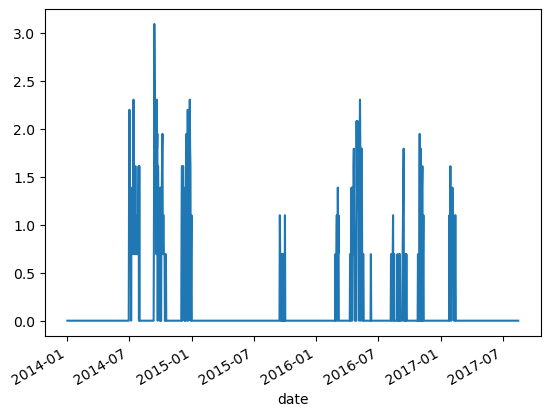

In [11]:
#Unpredictable skus
data.loc[data.sku == '10-BABY CARE', 'sales_1'].plot()

In [12]:
#skus with zero consumption in 2017 and nonzero in previous periods
strange_skus = np.setdiff1d(sku_1, sku_0)

In [13]:
len(strange_skus)

43

<AxesSubplot:xlabel='date'>

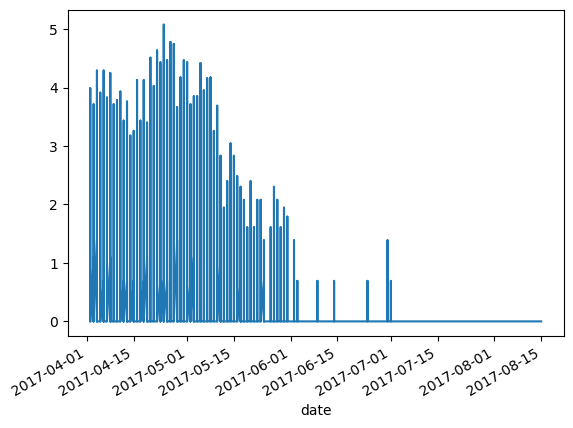

In [14]:
data.loc[(data.index > '2017-04') & (data.sku.isin(strange_skus)), 'sales_1'].plot()

##### `It's better to delete these skus also`

In [15]:
sku_1 = np.union1d(sku_1, sku_0)

In [16]:
len(sku_1)

102

In [17]:
dg2 = data.groupby(['sku', 'year'])['sales_1'].sum().reset_index()

In [18]:
dg2['cs'] = dg2.groupby(['sku'])['sales_1'].expanding(1).sum().values

In [19]:
#sksu with zero consumption before 2017 and nonzero in 2017
sku_2 = dg2.loc[(dg2.year == 2017) &\
            (dg2.sales_1 >0) &\
                (dg2.cs == dg2.sales_1), 'sku'].unique()

In [20]:
len(sku_2)

32

##### `It looks like 52 store opened in 2017`

<AxesSubplot:xlabel='date'>

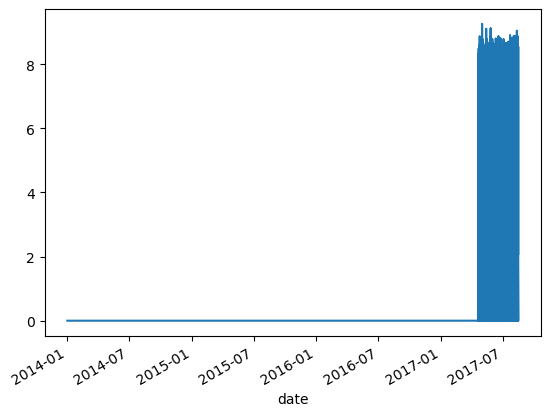

In [21]:
#sales for 52 store
data.loc[data.store_nbr == 52, 'sales_1'].plot()

In [22]:
#sksu with zero consumption before 2016 and nonzero in 2016
sku_3 = dg2.loc[(dg2.year == 2016) &\
            (dg2.sales_1 > 0) &\
                (dg2.cs == dg2.sales_1), 'sku'].unique()

In [23]:
len(sku_3)

46

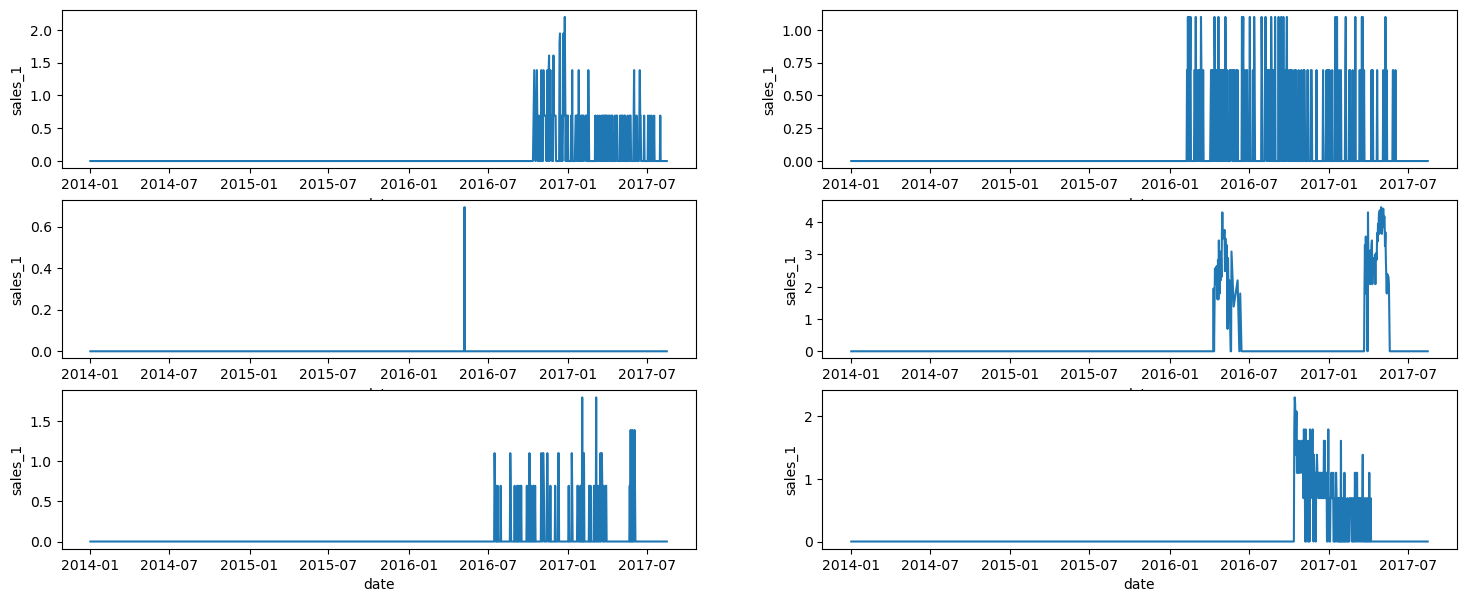

In [24]:
fig, axes = plt.subplots(3, 2, figsize = (18,7))
for n in range(6):
    sns.lineplot(data = data.loc[data.sku == sku_3[n], 'sales_1'], ax=axes[n//2][n%2])

##### `let's handle all such cases`

In [25]:
data['cumsum'] = data.groupby('sku')['sales_1'].expanding(1).sum().reset_index().set_index('date').sort_values(['date', 'sku'])['sales_1']

In [26]:
y_cols = [x for x in data.columns if x.startswith('sales')]
x_cols = [x for x in data.columns if x not in y_cols]

In [27]:
prom_cols = [x for x in data.columns if x.startswith('onprom')]

In [28]:
#it's not a category feature
data.loc[:, prom_cols] = data.loc[:, prom_cols].astype('float16')

In [29]:
#reduce memory for int, obj cols
int_cols = [col for col in data.select_dtypes(["int64", 'object'])]

In [30]:
data.loc[:, int_cols] = data.loc[:, int_cols].astype('category')

In [31]:
#reduce memory for float cols
float_cols = [col for col in data.select_dtypes(["float64"])]
data.loc[:, float_cols] = data.loc[:, float_cols].astype('float32')

### Feature analysis

In [32]:
# data.loc[:, x_cols].columns[51:]

In [33]:
base_features = ['sku', 'store_nbr', 'family', 'day', 'week', 'month', 'year', 'trend',
       's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
       'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'sin(1,freq=M)',
       'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 'sin(3,freq=M)',
       'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)',
       'onpromotion_1', 'onpromotion_2', 'onpromotion_3', 'onpromotion_4',
       'onpromotion_5', 'onpromotion_6', 'onpromotion_7', 'onpromotion_8',
       'onpromotion_9', 'onpromotion_10', 'onpromotion_11', 'onpromotion_12',
       'onpromotion_13', 'onpromotion_14', 'onpromotion_15', 'onpromotion_16',
       'y_lag_30', 'y_lag_60', 'y_lag_182', 'y_lag_364', 'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6',
       'MA_7', 'MA_8', 'MA_9', 'MA_10', 'MA_11', 'MA_12', 'MA_13', 'MA_14',
       'MA_30', 'MA_60', 'MA_90', 'MA_182', 'MA_364', 'EMA_0.6', 'EMA_0.65',
       'EMA_0.7', 'EMA_0.75', 'EMA_0.8', 'EMA_0.85', 'EMA_0.9', 'city',
       'state', 'type', 'cluster', 'cluster_sku', 'dcoilwtico', 'tr_10', 'tr_20', 'tr_30',
       'tr_1', 'tr_2', 'tr_3', 'oil_10', 'oil_20', 'oil_30', 'oil_1', 'oil_2',
       'oil_3', 'oil_c_5', 'oil_c_10', 'oil_c_15', 'promos_c_5', 'promos_c_10',
       'promos_c_15', 'total_promo', 'holiday', 'y_lag_14', 'y_lag_13', 'y_lag_12', 'y_lag_11',
        'y_lag_10', 'y_lag_9', 'y_lag_8', 'y_lag_7', 'y_lag_6', 'y_lag_5',
                 'y_lag_4', 'y_lag_3', 'y_lag_2', 'y_lag_1']

In [34]:
# #features for volatility standardization
# f_std = ['y_lag_30', 'y_lag_60', 'y_lag_182', 'y_lag_364', 'MA_2',
#          'MA_3', 'MA_4', 'MA_5', 'MA_6','MA_7', 'MA_8', 'MA_9', 'MA_10',
#          'MA_11', 'MA_12', 'MA_13', 'MA_14','MA_30', 'MA_60', 'MA_90', 'MA_182',
#          'MA_364', 'EMA_0.6', 'EMA_0.65', 'EMA_0.7', 'EMA_0.75', 'EMA_0.8', 'EMA_0.85',
#          'EMA_0.9', 'y_lag_14', 'y_lag_13', 'y_lag_12', 'y_lag_11', 'y_lag_10', 'y_lag_9',
#          'y_lag_8', 'y_lag_7', 'y_lag_6', 'y_lag_5', 'y_lag_4', 'y_lag_3', 'y_lag_2', 'y_lag_1']

In [35]:
# # volatility standardization
# data.loc[:'2017-07-19', f_std] = data.loc[:'2017-07-19', f_std].apply(lambda x: x/x.std(), axis = 0)
# data.loc['2017-07-20':'2017-08-16', f_std] = data.loc['2017-07-20':'2017-08-16', f_std].apply(lambda x: x/x.std(), axis = 0)

In [36]:
#for Kaggle
final = data.loc['2017-08-16'].copy()
#for comparing approaches
holdout = data.loc['2017-07-20' :\
                       '2017-08-15'].copy()

In [37]:
final.shape[0]

1782

In [38]:
data = data.loc[~data.sku.isin(sku_1)]

In [39]:
#test split
test = data.loc[(data.index<holdout.index.min()) &\
                   (data.index >= '2017-05-01')]
train = data.loc[data.index < test.index.min()]

In [40]:
train = train.loc[~(train['cumsum'] == 0)]

In [41]:
train.dropna(inplace=True)

In [42]:
# + we'll add onpromotion

### MI score

##### `sales+1`

In [43]:
from ts_tools import make_mi_scores, plot_mi_scores

In [44]:
x_1 = base_features.copy()

In [45]:
X = train.loc['2017':, x_1].copy().reset_index(drop = True)
y = train.loc['2017':, 'sales_1'].copy().reset_index(drop = True)

# Label encoding for categoricals
for colname in X.select_dtypes(["category"]):
    X[colname], _ = X[colname].factorize()

In [46]:
discrete_features = np.where(X.dtypes == np.int64)[0]

In [47]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

MA_30          1.672085
MA_60          1.665081
MA_14          1.653382
MA_90          1.653040
MA_364         1.641763
                 ...   
city           0.000000
week           0.000000
month          0.000000
year           0.000000
cluster_sku    0.000000
Name: MI Scores, Length: 116, dtype: float64

In [48]:
mi_scores[-20:]

s(2,7)         0.045487
s(1,7)         0.045392
s(5,7)         0.045344
s(3,7)         0.044330
s(6,7)         0.042744
s(7,7)         0.042713
s(4,7)         0.041749
day            0.000000
type           0.000000
holiday        0.000000
cluster        0.000000
state          0.000000
store_nbr      0.000000
total_promo    0.000000
family         0.000000
city           0.000000
week           0.000000
month          0.000000
year           0.000000
cluster_sku    0.000000
Name: MI Scores, dtype: float64

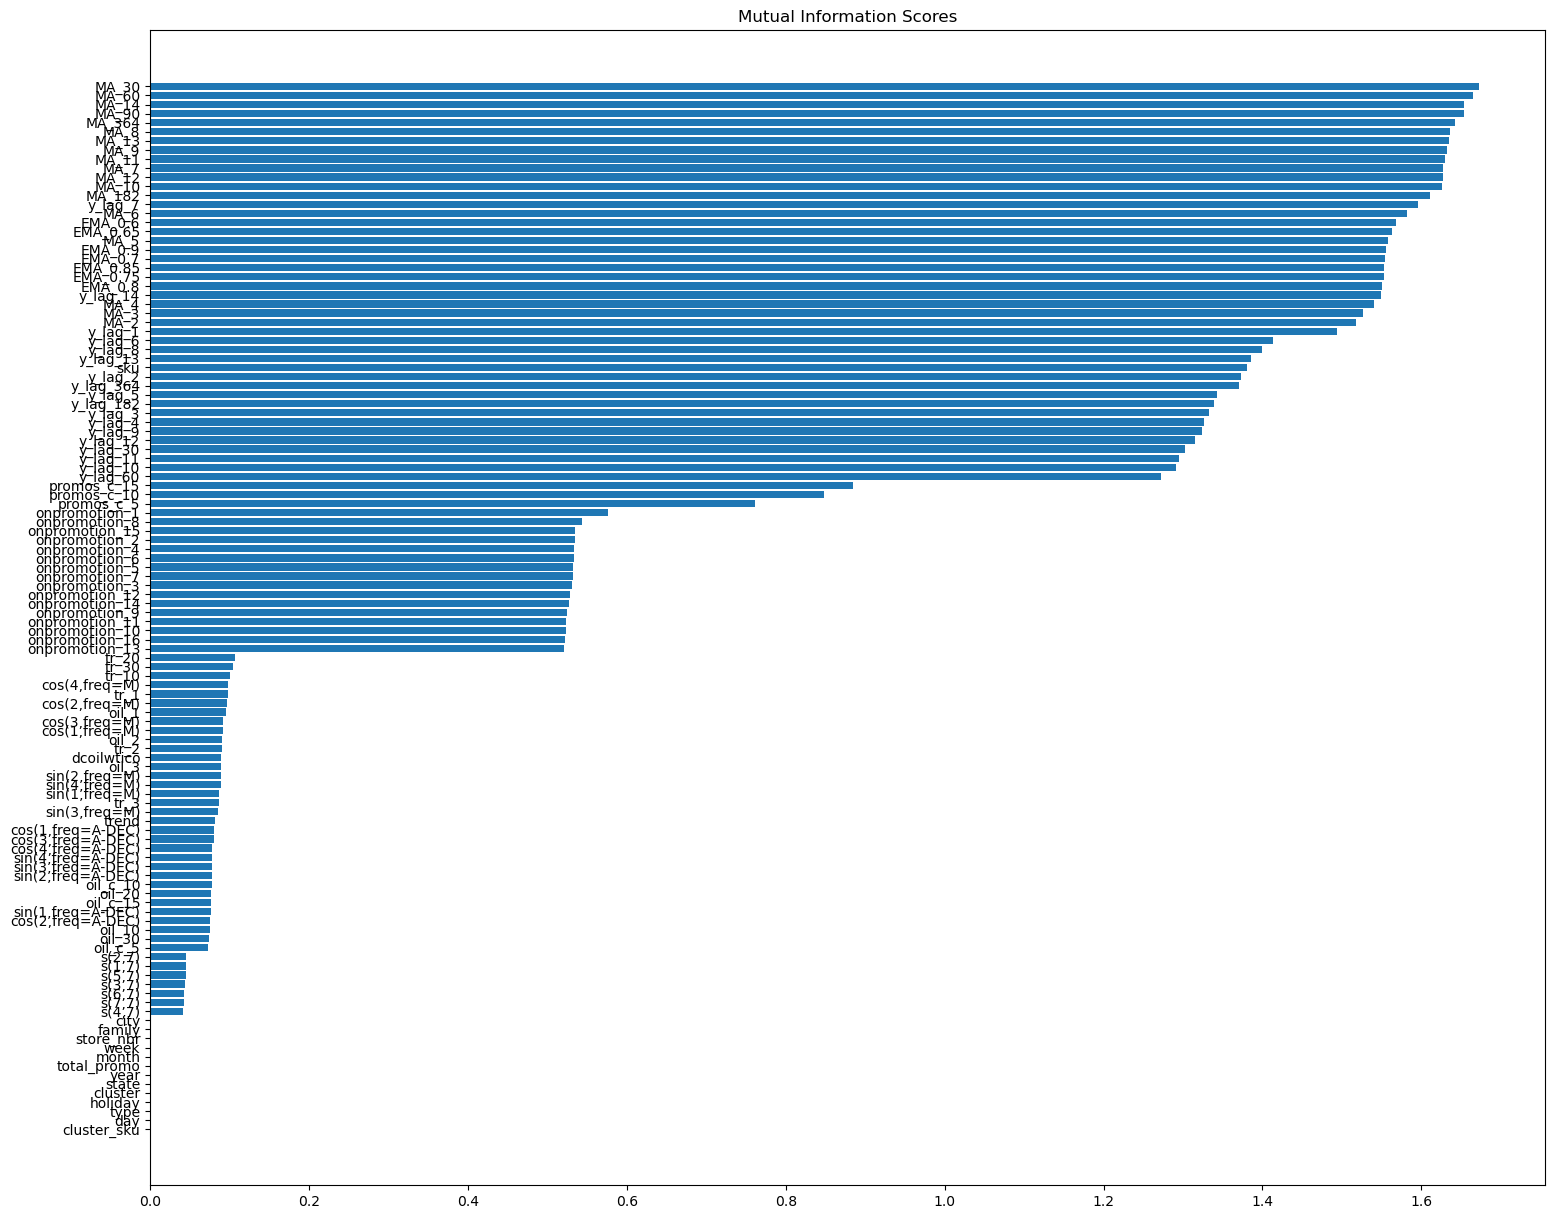

In [49]:
plt.figure(dpi=100, figsize=(18, 15))
plot_mi_scores(mi_scores)

##### `sales+16`

In [50]:
# x_16 = base_features.copy()
# x_16.append('onpromotion_1')

In [51]:
# X = train.loc['2017':, x_16].copy().reset_index(drop = True)
# y = train.loc['2017':, 'sales_16'].copy().reset_index(drop = True)

# # Label encoding for categoricals
# for colname in X.select_dtypes(["category"]):
#     X[colname], _ = X[colname].factorize()

In [52]:
# mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores  # show a few features with their MI scores

In [53]:
# plt.figure(dpi=100, figsize=(18, 15))
# plot_mi_scores(mi_scores)

In [54]:
x_cols = base_features.copy()

In [55]:
l1 = len(x_cols)

In [56]:
l1

116

### Pairplot

In [57]:
features_1 = ['promos_c_15', 'MA_6', 'y_lag_7', 'MA_60']

In [58]:
df_ = data.groupby(['date', 'store_nbr'])['promos_c_15', 'MA_6', 'y_lag_7', 'MA_60', 'sales_1'].sum().reset_index()

In [59]:
df_ = df_.loc[df_.store_nbr == 2].set_index('date')

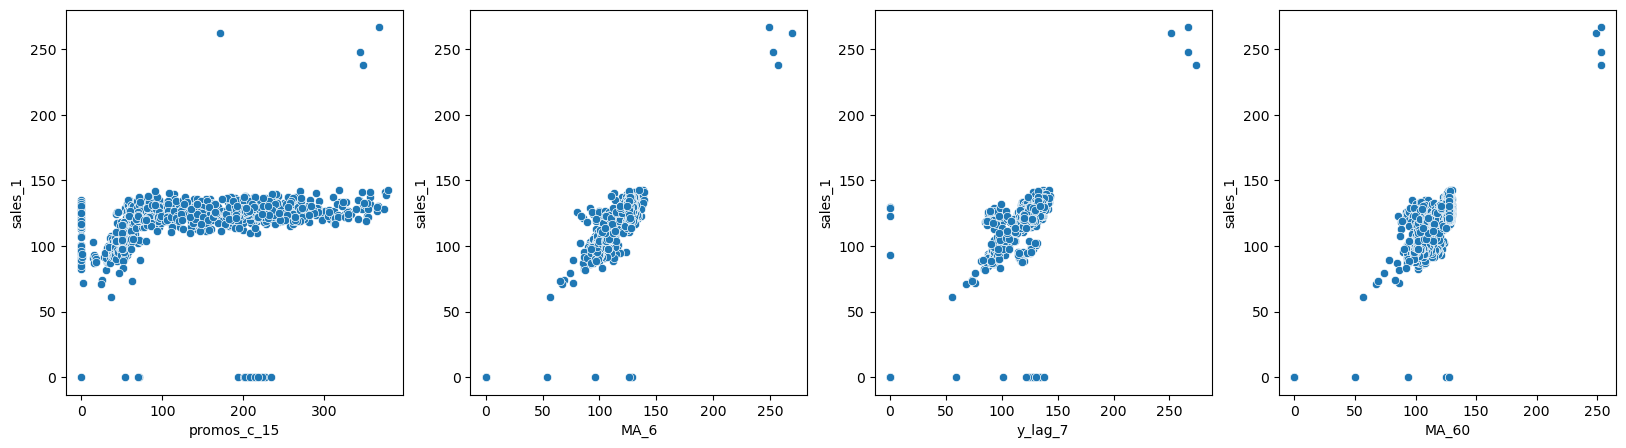

In [60]:
rows = int(len(features_1)//4+1*(len(features_1)%4 != 0))
plt.figure(figsize = (20,rows*5))
for n, _ in enumerate(features_1):
    ax = plt.subplot(rows, 4, n+1)
    sns.scatterplot(data = df_, x = _, y = 'sales_1', ax = ax)
    # try:
    #     # sns.kdeplot(data = train_data, x = _, ax = ax, shade = True)
    # except:
    #     continue
plt.show()

### Using Lasso output as an input to catboost and rf

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler

In [62]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

In [63]:
from sklearn.decomposition import PCA, FactorAnalysis

In [64]:
cat_selector = make_column_selector(dtype_include='category')
num_selector = make_column_selector(dtype_include=np.number)

In [65]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = StandardScaler()

In [66]:
linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector))

In [67]:
from sklearn.linear_model import LassoCV,RidgeCV
lasso_pipeline = make_pipeline(linear_preprocessor, Lasso(alpha=0.0075))
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C654058A30>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C654058550>)])),
                ('lasso', Lasso(alpha=0.0075))])

In [ ]:
train_ = train.iloc[np.random.randint(0, train.shape[0], 5*10**4)]

In [ ]:
import time
st = time.time()
lasso_pipeline.fit(train_.loc[:, x_cols], train_['sales_10'])
print('Execution time:', time.time() - st, 'seconds')

In [98]:
test['yy_10'] = lasso_pipeline.predict(test.loc[:, x_cols])

In [99]:
holdout['yy_10'] = lasso_pipeline.predict(holdout.loc[:, x_cols])

In [100]:
mean_absolute_error(np.expm1(test['sales_10']), np.expm1(test['MA_30']))

118.68235

In [101]:
mean_absolute_error(np.expm1(test['sales_10']), np.expm1(test['yy_10']))

111.74352603235477

In [102]:
mask2 = holdout.loc[:, y_cols[9]].notna()
mean_absolute_error(np.expm1(holdout.loc[mask2, 'sales_10']), np.expm1(holdout.loc[mask2, 'MA_30']))

103.14313

In [103]:
mean_absolute_error(np.expm1(holdout.loc[mask2, 'sales_10']), np.expm1(holdout.loc[mask2, 'yy_10']))

93.2113300229968

<AxesSubplot: xlabel='date'>

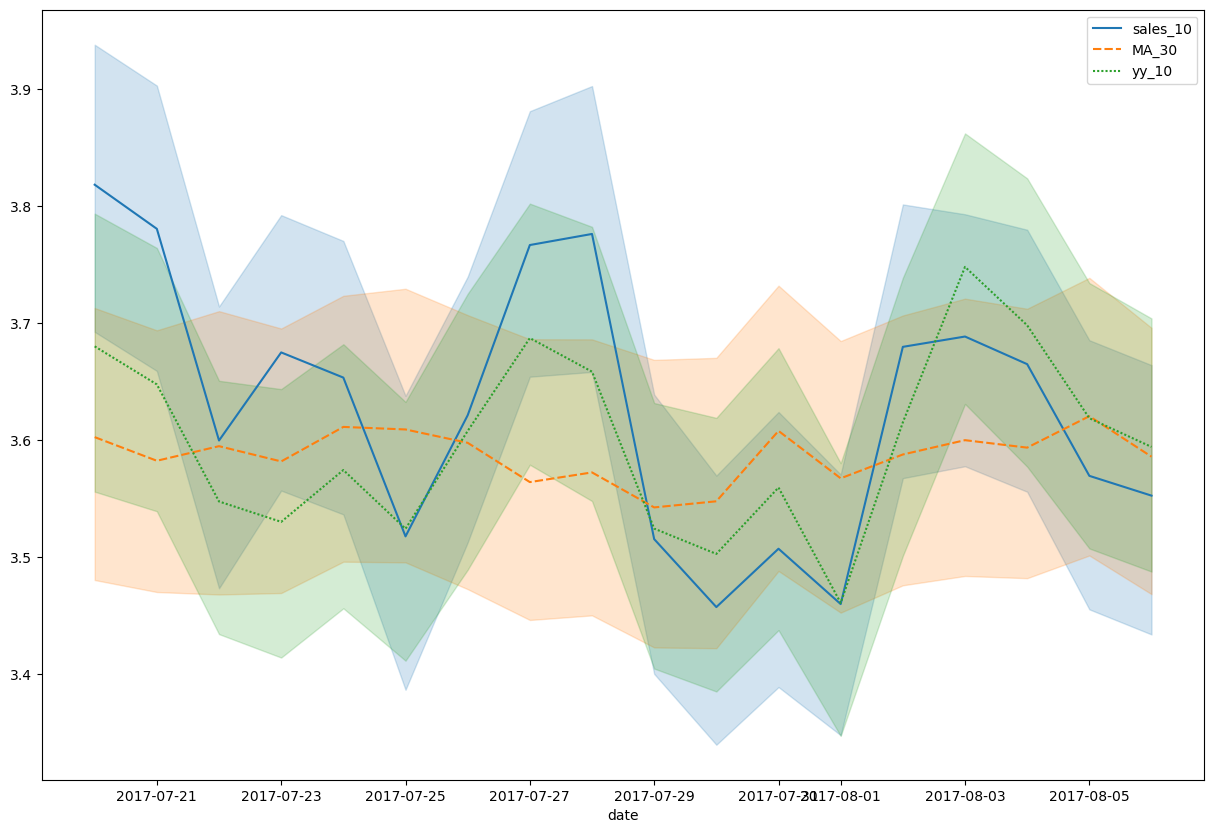

In [104]:
plt.figure(figsize = (15,10))
sns.lineplot(holdout.loc[mask2, ['sales_10', 'MA_30', 'yy_10']])

In [105]:
from tqdm.notebook import trange, tqdm

In [82]:
st = time.time()
for seed in trange(len(y_cols)):
    x_columns = x_cols.copy()
    
    lasso_pipeline['lasso'].set_params(alpha = 0.0025*(1+0.2*(seed+1)))
    lasso_pipeline.fit(train_.loc[:, x_columns], train_[f'sales_{seed+1}'])
    
    #output of model as a feature for the next one
    x_cols.insert(l1+seed, f'y_{seed+1}')
    
    for df_i in [train_, holdout]:
        df_i[f'y_{seed+1}'] = 0
        df_i.loc[~(df_i.sku.isin(sku_1)), f'y_{seed+1}'] =\
            lasso_pipeline.predict(df_i.loc[~(df_i.sku.isin(sku_1)), x_columns])
        df_i[f'y_{seed+1}'] = df_i[f'y_{seed+1}'].clip(0.0)
        df_i['new_MA_7'] = df_i.loc[:, x_cols].iloc[:, (l1-6+seed):l1+1+seed].mean(1)
        df_i['new_MA_9'] = df_i.loc[:, x_cols].iloc[:, (l1-8+seed):l1+1+seed].mean(1)
        df_i['new_MA_15'] = df_i.loc[:, x_cols].iloc[:, (l1-15+seed):l1+1+seed].mean(1)
        df_i['new_ema'] = df_i.loc[:, x_cols].iloc[:, (l1-15):l1+1+seed].mean(1)
        
    if seed == 0:
        for col_ in ['new_MA_7', 'new_MA_9', 'new_MA_15', 'new_ema']:
            x_cols.append(col_)
            
    print(f'End of the round {seed+1}. Time passed:', time.time() - st, 'seconds')
    
print('Execution time:', time.time() - st, 'seconds')

  0%|          | 0/16 [00:00<?, ?it/s]

End of the round 1. Time passed: 13.538146734237671 seconds
End of the round 2. Time passed: 27.245890617370605 seconds
End of the round 3. Time passed: 40.9436674118042 seconds
End of the round 4. Time passed: 54.27321243286133 seconds
End of the round 5. Time passed: 67.38355922698975 seconds
End of the round 6. Time passed: 80.45473980903625 seconds
End of the round 7. Time passed: 93.81437158584595 seconds
End of the round 8. Time passed: 107.07294225692749 seconds
End of the round 9. Time passed: 120.34343338012695 seconds
End of the round 10. Time passed: 133.06946468353271 seconds
End of the round 11. Time passed: 146.21241188049316 seconds
End of the round 12. Time passed: 159.37378406524658 seconds
End of the round 13. Time passed: 172.51890325546265 seconds
End of the round 14. Time passed: 185.72271728515625 seconds
End of the round 15. Time passed: 198.92972707748413 seconds
End of the round 16. Time passed: 211.5501730442047 seconds
Execution time: 211.55128622055054 secon

In [83]:
results = pd.DataFrame(columns=range(1,17))
for n in range(len(y_cols)):
    mask2 = holdout.loc[:, y_cols[n]].notna()
    results.loc['model', n+1] = mean_absolute_error(
            np.expm1(holdout.loc[mask2, y_cols[n]]),
            np.expm1(holdout.loc[mask2, f'y_{n+1}']))
    results.loc['MA', n+1] = mean_absolute_error(
            np.expm1(holdout.loc[mask2, y_cols[n]]),
            np.expm1(holdout.loc[mask2, 'MA_30']))

In [84]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,65.904912,77.815857,87.539187,83.246781,88.202519,93.775753,89.919005,90.74926,95.403691,94.645405,89.847533,90.694752,95.187737,94.852625,102.063204,96.860133
MA,88.780014,96.316475,98.007744,99.000366,96.886292,97.233871,97.90786,99.091377,101.369911,103.143127,101.117699,94.754608,94.564682,91.958908,92.577171,96.437553


## Random forest estimator

In [64]:
rf_preprocessor = make_column_transformer((cat_linear_processor, cat_selector))

In [65]:
from sklearn.ensemble import RandomForestRegressor
rf_pipeline = make_pipeline(rf_preprocessor, RandomForestRegressor())
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0014c27040>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [68]:
train_ = train.iloc[np.random.randint(0, train.shape[0], 5*10**4)]

In [ ]:
import time
st = time.time()
rf_pipeline.fit(train_.loc[:, x_cols], train_['sales_10'])
print('Execution time:', time.time() - st, 'seconds')

Execution time: 598.8859717845917 seconds


In [ ]:
test['yy_10'] = rf_pipeline.predict(test.loc[:, x_cols])

In [ ]:
holdout['yy_10'] = rf_pipeline.predict(holdout.loc[:, x_cols])

In [ ]:
mean_absolute_error(np.expm1(test['sales_10']), np.expm1(test['MA_30']))

118.68235

In [ ]:
mean_absolute_error(np.expm1(test['sales_10']), np.expm1(test['yy_10']))

78.9112344492055

In [ ]:
mask2 = holdout.loc[:, y_cols[9]].notna()
mean_absolute_error(np.expm1(holdout.loc[mask2, 'sales_10']), np.expm1(holdout.loc[mask2, 'MA_30']))

103.14313

In [ ]:
mean_absolute_error(np.expm1(holdout.loc[mask2, 'sales_10']), np.expm1(holdout.loc[mask2, 'yy_10']))

82.32432600930828

<AxesSubplot: xlabel='date'>

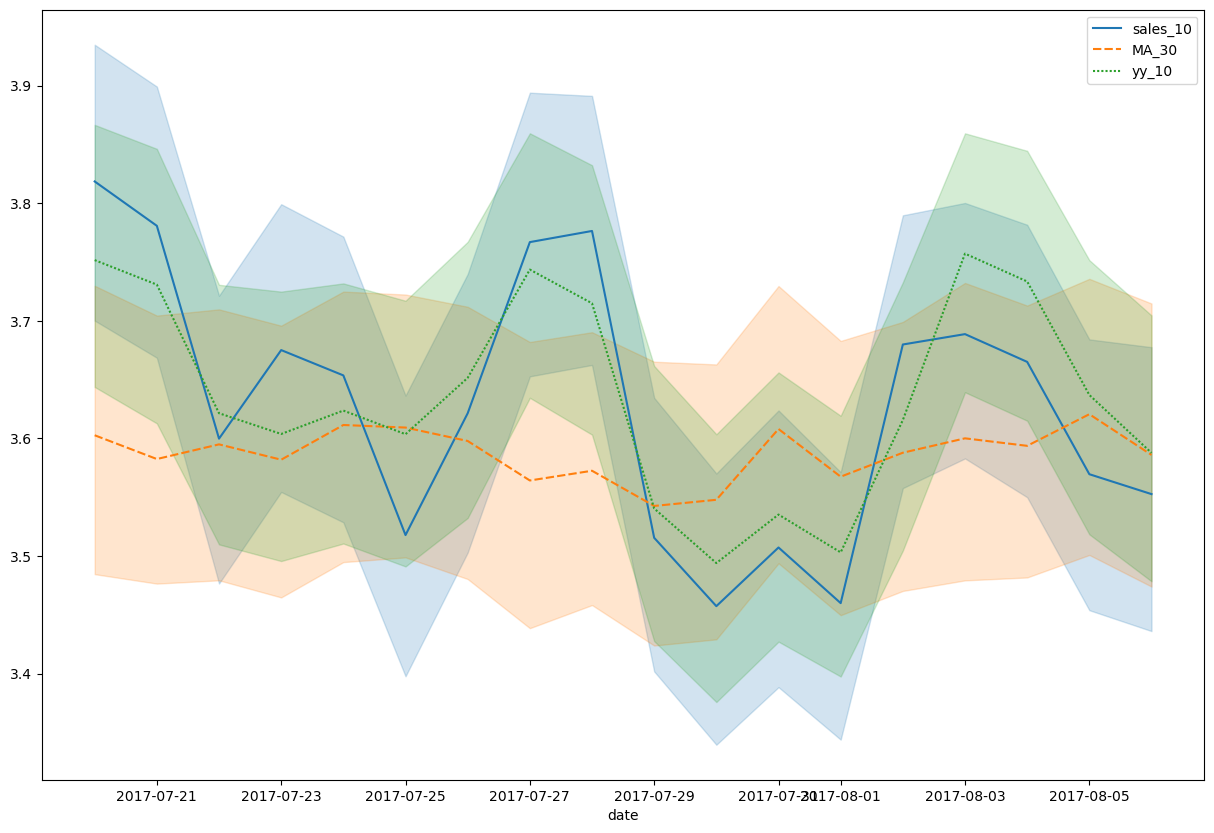

In [76]:
plt.figure(figsize = (15,10))
sns.lineplot(holdout.loc[mask2, ['sales_10', 'MA_30', 'yy_10']])

In [71]:
train1 = pd.concat([train,test])

In [72]:
train_ = train1.iloc[np.random.randint(0, train1.shape[0], 1*10**4)]
train_ = train_.sort_index()

In [73]:
size_of_test = train_.loc[(train_.index.year == 2017) &\
                  (train_.index.month == 4)].shape[0]
size_of_test

250

In [75]:
%%time
def objective(trial):
    
    data = train_.loc[:, x_cols]
    target = train_.loc[:, 'sales_1']
    ## Категориальные признаки

    # cat_features = []          
#     param = {
#         'depth' : trial.suggest_int("depth", 3, 6),
#         'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.5),
#         'l2_leaf_reg' : trial.suggest_float('l2_leaf_reg', 0.01, 10)}

#     estimator = CatBoostRegressor(**param,
#                                   cat_features = cat_features,
#                                   iterations=300,
#                                   random_state = 7,
#                                   silent=True)
    param = {
         'min_impurity_decrease': trial.suggest_float("min_impurity_decrease", 0, 2),
         'n_estimators': trial.suggest_int("n_estimators", 50, 1100),
         "max_features": trial.suggest_float("max_features", 0.2, 1)
        }
    estimator = make_pipeline(linear_preprocessor, RandomForestRegressor(**param, random_state=34, n_jobs=-1))

    mse = cross_val_score(estimator, data, target, scoring='neg_mean_squared_error',
                          cv=TimeSeriesSplit(n_splits=3, test_size=size_of_test*2), n_jobs=-1).mean()
    
    return mse
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200, timeout=10000)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 182
Best trial:
  Value: -0.1835031519548306
  Params: 
    min_impurity_decrease: 1.4551811789047025e-05
    n_estimators: 1081
    max_features: 0.820040496279392
CPU times: user 9.28 s, sys: 5.16 s, total: 14.4 s
Wall time: 2h 47min


In [76]:
study.best_params

{'min_impurity_decrease': 1.4551811789047025e-05,
 'n_estimators': 1081,
 'max_features': 0.820040496279392}

In [77]:
rf_pipeline = make_pipeline(linear_preprocessor, RandomForestRegressor(**study.best_params, random_state=34, n_jobs=-1))

In [78]:
from tqdm.notebook import trange, tqdm

In [79]:
st = time.time()
for seed in trange(len(y_cols)):
    
    x_columns = x_cols.copy()
    start = '2014'
    
    #new train for lasso        
    train__ = train1.iloc[np.random.randint(0, train1.shape[0], 2*10**4)].copy()
    
    #lasso output
    lasso_pipeline['lasso'].set_params(alpha = 0.0025*(1+0.2*(seed+1)))
    lasso_pipeline.fit(train__.loc[start:, x_columns], train__.loc[start:, f'sales_{seed+1}'])
    for df_i in [train1, holdout, final]:
        df_i[f'lasso_{seed+1}'] = 0
        df_i.loc[~(df_i.sku.isin(sku_1)), f'lasso_{seed+1}'] =\
            lasso_pipeline.predict(df_i.loc[~(df_i.sku.isin(sku_1)), x_columns])
        df_i[f'lasso_{seed+1}'] = df_i[f'lasso_{seed+1}'].clip(0.0)
        
    x_columns.append(f'lasso_{seed+1}')
    
    #new train to avoid overfitting on previous step preds
    train_ = train1.iloc[np.random.randint(0, train1.shape[0], 3*10**4)].copy()
    
    rf_pipeline.fit(train_.loc[:, x_columns], train_[f'sales_{seed+1}'])
    
    #output of model as a feature for the next one
    x_cols.insert(l1+seed, f'y_{seed+1}')
    
    for df_i in [train1, holdout, final]:
        df_i[f'y_{seed+1}'] = 0
        df_i.loc[~(df_i.sku.isin(sku_1)), f'y_{seed+1}'] =\
            rf_pipeline.predict(df_i.loc[~(df_i.sku.isin(sku_1)), x_columns])
        df_i[f'y_{seed+1}'] = df_i[f'y_{seed+1}'].clip(0.0)
        df_i['new_MA_7'] = df_i.loc[:, x_cols].iloc[:, (l1-6+seed):l1+1+seed].mean(1)
        df_i['new_MA_9'] = df_i.loc[:, x_cols].iloc[:, (l1-8+seed):l1+1+seed].mean(1)
        df_i['new_MA_15'] = df_i.loc[:, x_cols].iloc[:, (l1-15+seed):l1+1+seed].mean(1)
        df_i['new_ema'] = df_i.loc[:, x_cols].iloc[:, (l1-15):l1+1+seed].mean(1)
        
    if seed == 0:
        for col_ in ['new_MA_7', 'new_MA_9', 'new_MA_15', 'new_ema']:
            x_cols.append(col_)
            
    print(f'End of the round {seed+1}. Time passed:', time.time() - st, 'seconds')
    
print('Execution time:', time.time() - st, 'seconds')

  0%|          | 0/16 [00:00<?, ?it/s]

End of the round 1. Time passed: 1150.7029836177826 seconds
End of the round 2. Time passed: 2371.3025557994843 seconds
End of the round 3. Time passed: 3621.6618654727936 seconds
End of the round 4. Time passed: 4998.363453865051 seconds
End of the round 5. Time passed: 6398.1928424835205 seconds
End of the round 6. Time passed: 7808.108488321304 seconds
End of the round 7. Time passed: 9233.256978988647 seconds
End of the round 8. Time passed: 10703.840126752853 seconds
End of the round 9. Time passed: 12176.348456382751 seconds
End of the round 10. Time passed: 13630.697992801666 seconds
End of the round 11. Time passed: 15061.502927064896 seconds
End of the round 12. Time passed: 16531.277257442474 seconds
End of the round 13. Time passed: 18045.27921152115 seconds
End of the round 14. Time passed: 19566.60720396042 seconds
End of the round 15. Time passed: 21076.82569694519 seconds
End of the round 16. Time passed: 22627.587267398834 seconds
Execution time: 22627.602499723434 seco

In [80]:
results = pd.DataFrame(columns=range(1,17))
for n in range(len(y_cols)):
    mask2 = holdout.loc[:, y_cols[n]].notna()
    results.loc['model', n+1] = mean_absolute_error(
            np.expm1(holdout.loc[mask2, y_cols[n]]),
            np.expm1(holdout.loc[mask2, f'y_{n+1}']))
    results.loc['MA', n+1] = mean_absolute_error(
            np.expm1(holdout.loc[mask2, y_cols[n]]),
            np.expm1(holdout.loc[mask2, 'MA_30']))

In [81]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,59.221606,70.219416,70.52611,71.218145,75.354496,75.155093,77.13994,81.082681,82.215276,82.279197,89.838233,86.067954,83.867414,82.088006,74.896548,79.961091
MA,88.780014,96.316475,98.007744,99.000366,96.886292,97.233871,97.90786,99.091377,101.369911,103.143127,101.117699,94.754608,94.564682,91.958908,92.577171,96.437553


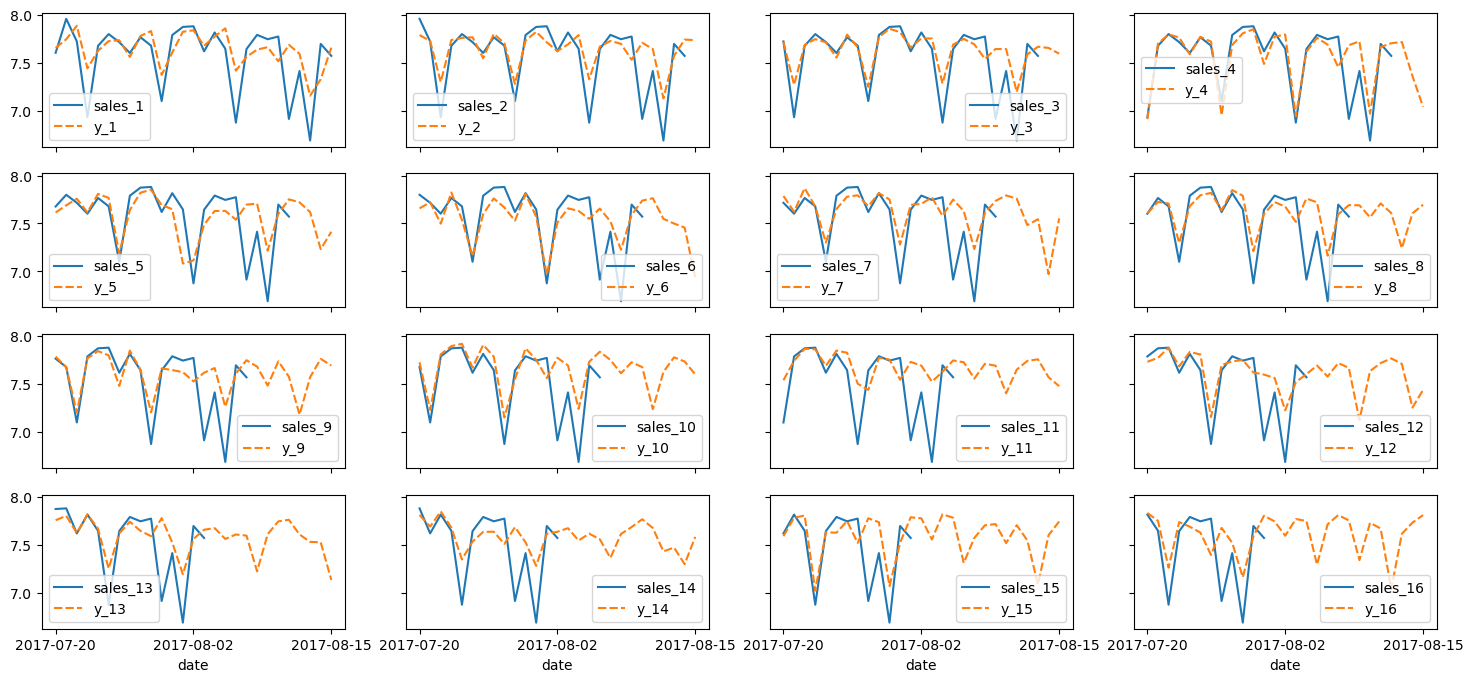

In [82]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 1) &\
             (holdout.family == 'BEVERAGES'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

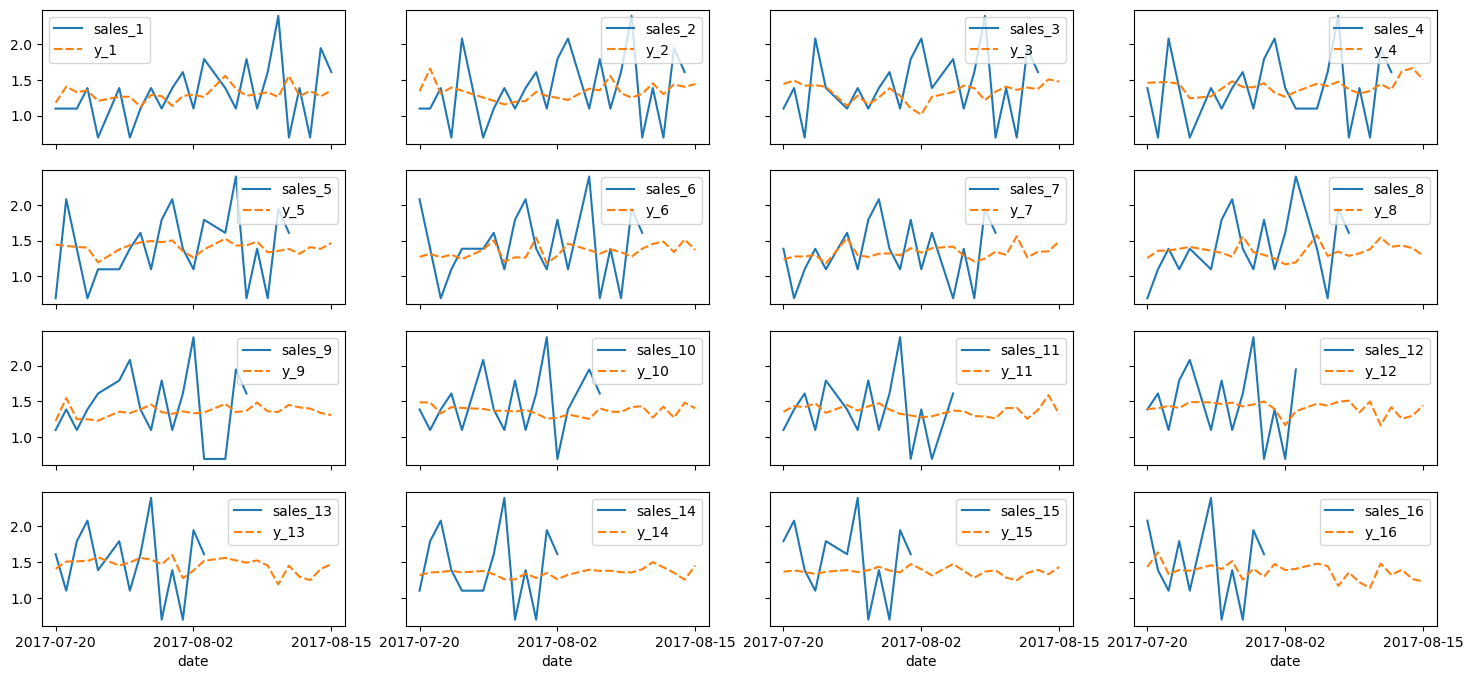

In [83]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 1) &\
             (holdout.family == 'BEAUTY'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

### final score = 0.41

## Catboost estimator

##### `I'll try to use outputs of the linear model as an input to the final estimator`

#### HP tuning

In [74]:
train1 = pd.concat([train,test])

In [75]:
# train_ = train1.iloc[np.random.randint(0, train1.shape[0], 1*10**4)]
# train_ = train_.sort_index()

In [76]:
size_of_test = train_.loc[(train_.index.year == 2017) &\
                  (train_.index.month == 4)].shape[0]
size_of_test

250

In [ ]:
%%time
def objective(trial):
    
    data = train_.loc[:, x_cols]
    target = train_.loc[:, 'sales_1']
    ## Категориальные признаки
    
    param = {
        'depth' : trial.suggest_int("depth", 5, 11),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.5),
        'l2_leaf_reg' : trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength' : trial.suggest_float('random_strength', 0.5, 2),
        }

    estimator = CatBoostRegressor(**param,
                                  iterations = 1200,
                                  cat_features = discrete_features,
                                  has_time = True,
                                  random_state = 7,
                                  silent=True)

    mse = cross_val_score(estimator, data, target, scoring='neg_mean_squared_error',
                          cv=TimeSeriesSplit(n_splits=3, test_size=size_of_test*2), n_jobs=-1).mean()
    
    return mse
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200, timeout=10000)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
#exp

In [77]:
train1 = pd.concat([train, test, holdout])

In [78]:
train1['ad'] = train1.sku.astype('str') + train1.index.astype('str')

In [79]:
x_cols = base_features.copy()

In [80]:
l1 = len(x_cols)
l1

116

In [81]:
#exp

In [82]:
test = train1.iloc[np.random.randint(0, train1.shape[0], 4*10**5)].copy()

In [83]:
# test = test.loc[test.index < '2017-07-01']

In [84]:
test = test.sort_index()

In [85]:
train = train1.loc[~train1.ad.isin(test['ad'].unique())].copy()

In [86]:
params = {
          'iterations': 5000,
          'depth': 9,
          'l2_leaf_reg': 3.5,
          'task_type': 'GPU',
          'verbose': 200,
          'border_count': 32,
          'random_strength': 1.1,
          'bootstrap_type': 'Bernoulli',
          # 'subsample': 0.1,
          # 'rsm': 0.7,
          'cat_features': discrete_features,
          'thread_count': -1,
          'has_time': True
    }

In [87]:
from tqdm.notebook import trange, tqdm

In [88]:
#Increase weights for closer observations
weights = pd.Series(np.linspace(0.3, 1.8, len(train.index.unique())), index=train.index.unique())

In [89]:
train['weights'] = weights

In [90]:
# train['weights'] = 1

In [91]:
train.loc['2017-06':, 'weights'] = 2
train.loc['2017-07':, 'weights'] = 3

In [92]:
for seed in trange(len(y_cols)):
    x_columns = x_cols.copy()
    # x_columns.append(f'onpromotion_{seed+1}')
    start = '2014'
    # if seed in [6,12,13]:
    #     start = '2015-10'
    
    np.random.seed(77+seed)
    
    #new train for lasso        
    train__ = train.iloc[np.random.randint(0, train.shape[0], 5*10**4)].copy()
    train__ = train__.loc[train__.loc[:, y_cols[seed]].notna()]
    
    #lasso output
    lasso_pipeline['lasso'].set_params(alpha = 0.0025*(1+0.2*(seed+1)))
    lasso_pipeline.fit(train__.loc[start:, x_columns], train__.loc[start:, f'sales_{seed+1}'])
    for df_i in [train, test, final]:
        df_i[f'lasso_{seed+1}'] = 0
        df_i.loc[~(df_i.sku.isin(sku_1)), f'lasso_{seed+1}'] =\
            lasso_pipeline.predict(df_i.loc[~(df_i.sku.isin(sku_1)), x_columns])
        df_i[f'lasso_{seed+1}'] = df_i[f'lasso_{seed+1}'].clip(0.0)
        
    x_columns.append(f'lasso_{seed+1}')
    
    #new train to avoid overfitting on previous step preds
    train_ = train.iloc[np.random.randint(0, train.shape[0], 5*10**5)].copy()
    train_ = train_.loc[train_.loc[:, y_cols[seed]].notna()]
    
    #catboost estimator
    cat = CatBoostRegressor(**params, random_state = seed+34)
    cat.fit(train_.loc[start:, x_columns], train_.loc[start:, y_cols[seed]],
           eval_set=(test.loc[test.loc[:, y_cols[seed]].notna(), x_columns],
                     test.loc[test.loc[:, y_cols[seed]].notna(), y_cols[seed]]),
            sample_weight=train_['weights'],
            early_stopping_rounds=300,
            use_best_model=True)
    
    #output of model as a feature for the next one
    x_cols.insert(l1+seed, f'y_{seed+1}')
    
    for df_i in [train, test, final]:
        df_i[f'y_{seed+1}'] = 0
        df_i.loc[~(df_i.sku.isin(sku_1)), f'y_{seed+1}'] =\
            cat.predict(df_i.loc[~(df_i.sku.isin(sku_1)), x_columns])
        df_i[f'y_{seed+1}'] = df_i[f'y_{seed+1}'].clip(0.0)
        df_i['new_MA_7'] = df_i.loc[:, x_cols].iloc[:, (l1-6+seed):l1+1+seed].mean(1)
        df_i['new_MA_9'] = df_i.loc[:, x_cols].iloc[:, (l1-8+seed):l1+1+seed].mean(1)
        df_i['new_MA_15'] = df_i.loc[:, x_cols].iloc[:, (l1-15+seed):l1+1+seed].mean(1)
        df_i['new_ema'] = df_i.loc[:, x_cols].iloc[:, (l1-15):l1+1+seed].mean(1)
    
    if seed == 0:
        for col_ in ['new_MA_7', 'new_MA_9', 'new_MA_15', 'new_ema']:
            x_cols.append(col_)

  0%|          | 0/16 [00:00<?, ?it/s]

0:	learn: 2.4514591	test: 2.4872504	best: 2.4872504 (0)	total: 82.6ms	remaining: 6m 52s
200:	learn: 0.4318917	test: 0.4446500	best: 0.4446500 (200)	total: 15s	remaining: 5m 57s
400:	learn: 0.4092625	test: 0.4180591	best: 0.4180591 (400)	total: 29.6s	remaining: 5m 39s
600:	learn: 0.3965150	test: 0.4068684	best: 0.4068684 (600)	total: 44.8s	remaining: 5m 27s
800:	learn: 0.3879882	test: 0.4008944	best: 0.4008944 (800)	total: 59.8s	remaining: 5m 13s
1000:	learn: 0.3809649	test: 0.3967159	best: 0.3967159 (1000)	total: 1m 14s	remaining: 4m 59s
1200:	learn: 0.3752775	test: 0.3941705	best: 0.3941705 (1200)	total: 1m 30s	remaining: 4m 44s
1400:	learn: 0.3699834	test: 0.3921185	best: 0.3921185 (1400)	total: 1m 45s	remaining: 4m 30s
1600:	learn: 0.3653685	test: 0.3906436	best: 0.3906436 (1600)	total: 2m	remaining: 4m 15s
1800:	learn: 0.3611697	test: 0.3893833	best: 0.3893833 (1800)	total: 2m 15s	remaining: 4m 1s
2000:	learn: 0.3569298	test: 0.3882165	best: 0.3882165 (2000)	total: 2m 31s	remaining

In [ ]:
# train_ = train.iloc[np.random.randint(0, train.shape[0], 5*10**5)].copy()

In [75]:
# train__ = train_.iloc[np.random.randint(0, train_.shape[0], 5*10**4)].copy()

In [112]:
# for seed in trange(len(y_cols)):
#     x_columns = x_cols.copy()
#     # x_columns.append(f'onpromotion_{seed+1}')
#     start = '2014'
#     # if seed in [6,12,13]:
#     #     start = '2015-10'
    
#     #new train for lasso        
#     train__ = train.iloc[np.random.randint(0, train.shape[0], 5.1*10**4)].copy()
#     train__ = train__.loc[:
    
#     #lasso output
#     lasso_pipeline['lasso'].set_params(alpha = 0.0025*(1+0.2*(seed+1)))
#     lasso_pipeline.fit(train__.loc[start:, x_columns], train__.loc[start:, f'sales_{seed+1}'])
#     for df_i in [train, test, holdout, final]:
#         df_i[f'lasso_{seed+1}'] = 0
#         df_i.loc[~(df_i.sku.isin(sku_1)), f'lasso_{seed+1}'] =\
#             lasso_pipeline.predict(df_i.loc[~(df_i.sku.isin(sku_1)), x_columns])
#         df_i[f'lasso_{seed+1}'] = df_i[f'lasso_{seed+1}'].clip(0.0)
        
#     x_columns.append(f'lasso_{seed+1}')
    
#     #new train to avoid overfitting on previous step preds
#     train_ = train.iloc[np.random.randint(0, train.shape[0], 5*10**5)].copy()
    
#     #catboost estimator
#     cat = CatBoostRegressor(**params, random_state = seed+34)
#     cat.fit(train_.loc[start:, x_columns], train_.loc[start:, y_cols[seed]],
#            eval_set=(test.loc[test.loc[:, y_cols[seed]].notna(), x_columns],
#                      test.loc[test.loc[:, y_cols[seed]].notna(), y_cols[seed]]),
#             sample_weight=train_['weights'],
#             early_stopping_rounds=300,
#             use_best_model=True)
    
#     #output of model as a feature for the next one
#     x_cols.insert(l1+seed, f'y_{seed+1}')
    
#     for df_i in [train, test, holdout, final]:
#         df_i[f'y_{seed+1}'] = 0
#         df_i.loc[~(df_i.sku.isin(sku_1)), f'y_{seed+1}'] =\
#             cat.predict(df_i.loc[~(df_i.sku.isin(sku_1)), x_columns])
#         df_i[f'y_{seed+1}'] = df_i[f'y_{seed+1}'].clip(0.0)
#         df_i['new_MA_7'] = df_i.loc[:, x_cols].iloc[:, (l1-6+seed):l1+1+seed].mean(1)
#         df_i['new_MA_9'] = df_i.loc[:, x_cols].iloc[:, (l1-8+seed):l1+1+seed].mean(1)
#         df_i['new_MA_15'] = df_i.loc[:, x_cols].iloc[:, (l1-15+seed):l1+1+seed].mean(1)
#         df_i['new_ema'] = df_i.loc[:, x_cols].iloc[:, (l1-15):l1+1+seed].mean(1)
    
#     if seed == 0:
#         for col_ in ['new_MA_7', 'new_MA_9', 'new_MA_15', 'new_ema']:
#             x_cols.append(col_)

In [93]:
holdout = test.copy()

In [94]:
results = pd.DataFrame(columns=range(1,17))
for n in range(len(y_cols)):
    mask2 = holdout.loc[:, y_cols[n]].notna()
    results.loc['model', n+1] = mean_absolute_error(
            np.expm1(holdout.loc[mask2, y_cols[n]]),
            np.expm1(holdout.loc[mask2, f'y_{n+1}']))
    results.loc['MA', n+1] = mean_absolute_error(
            np.expm1(holdout.loc[mask2, y_cols[n]]),
            np.expm1(holdout.loc[mask2, 'MA_30']))

In [95]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,52.147134,56.471543,55.714954,56.223323,57.076016,57.841284,57.795693,59.485049,60.026949,60.246177,60.641867,60.351597,59.431908,59.608819,60.033703,61.243458
MA,114.653671,120.267273,120.117378,121.155113,120.709053,118.758995,120.486588,122.693069,125.225906,125.555206,125.68705,125.022858,123.064079,124.377579,125.408112,127.324844


In [90]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,51.859333,55.882922,57.268462,57.497536,57.238438,58.129799,57.341925,58.340492,59.471709,60.841851,60.868397,59.135877,60.683831,59.485171,60.943861,61.236045
MA,113.387062,119.595947,121.015327,121.688606,120.926979,119.705421,120.571953,121.50193,125.114326,125.878815,125.587639,124.894623,123.276344,123.815681,125.500443,128.580719


In [150]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,49.436339,53.244269,52.271341,52.494765,53.837404,53.325025,53.21859,56.117491,57.114766,55.692303,55.274167,55.348817,55.883887,55.061176,57.119994,56.589261
MA,114.765976,120.464241,121.366936,121.217148,121.971611,119.288033,120.162933,123.914948,126.707802,125.800461,125.37088,124.48835,124.402649,123.760468,127.072044,128.631363


In [115]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,51.38374,56.295997,56.334813,57.078843,57.687926,56.459662,56.677965,58.973205,59.520139,58.895988,59.714419,60.590802,59.292263,59.01787,61.075375,60.180293
MA,114.765976,120.464241,121.366936,121.217148,121.971611,119.288033,120.162933,123.914948,126.707802,125.800461,125.37088,124.48835,124.402649,123.760468,127.072044,128.631363


#### Example for highrunners

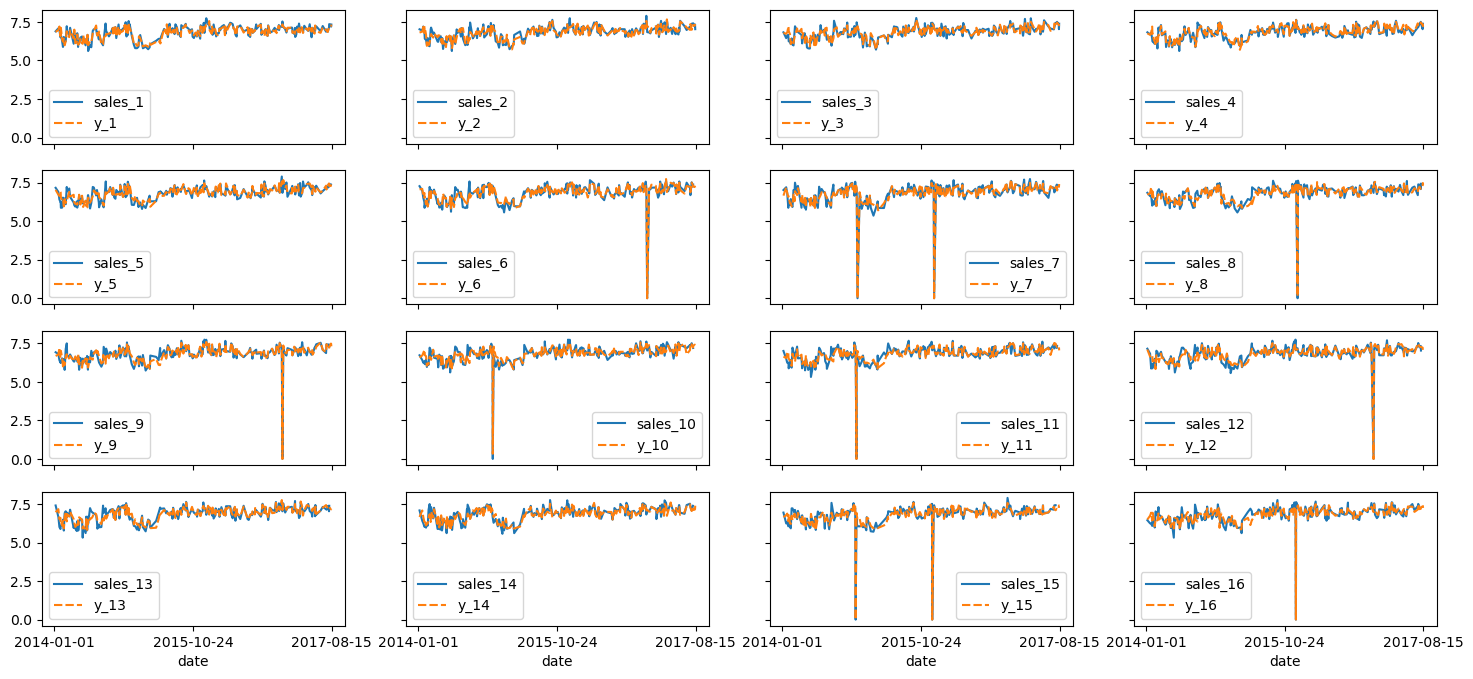

In [96]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(data = holdout.loc[(holdout.store_nbr == 10) & (holdout.family == 'BEVERAGES'),
                                    [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

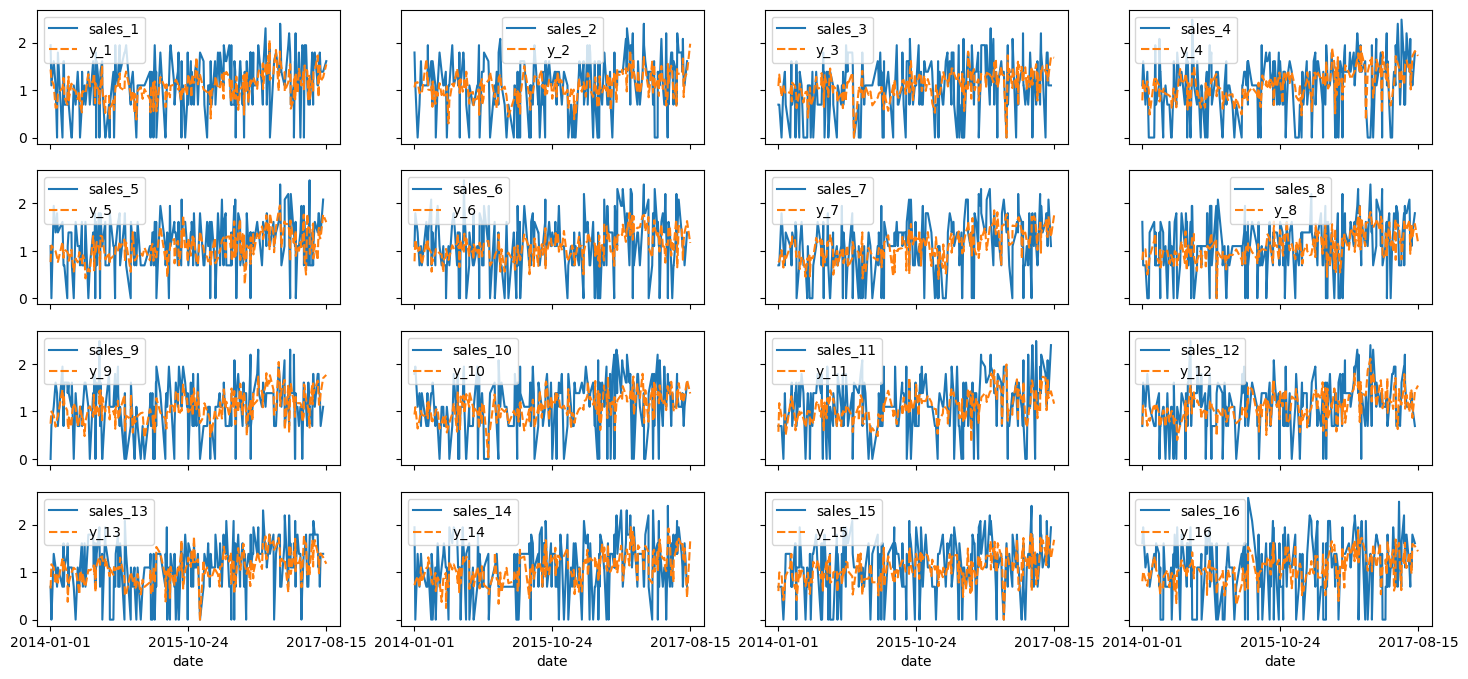

In [97]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(data = holdout.loc[(holdout.store_nbr == 1) &\
             (holdout.family == 'BEAUTY'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

In [98]:
feature_importance_df = cat.get_feature_importance(prettified=True)

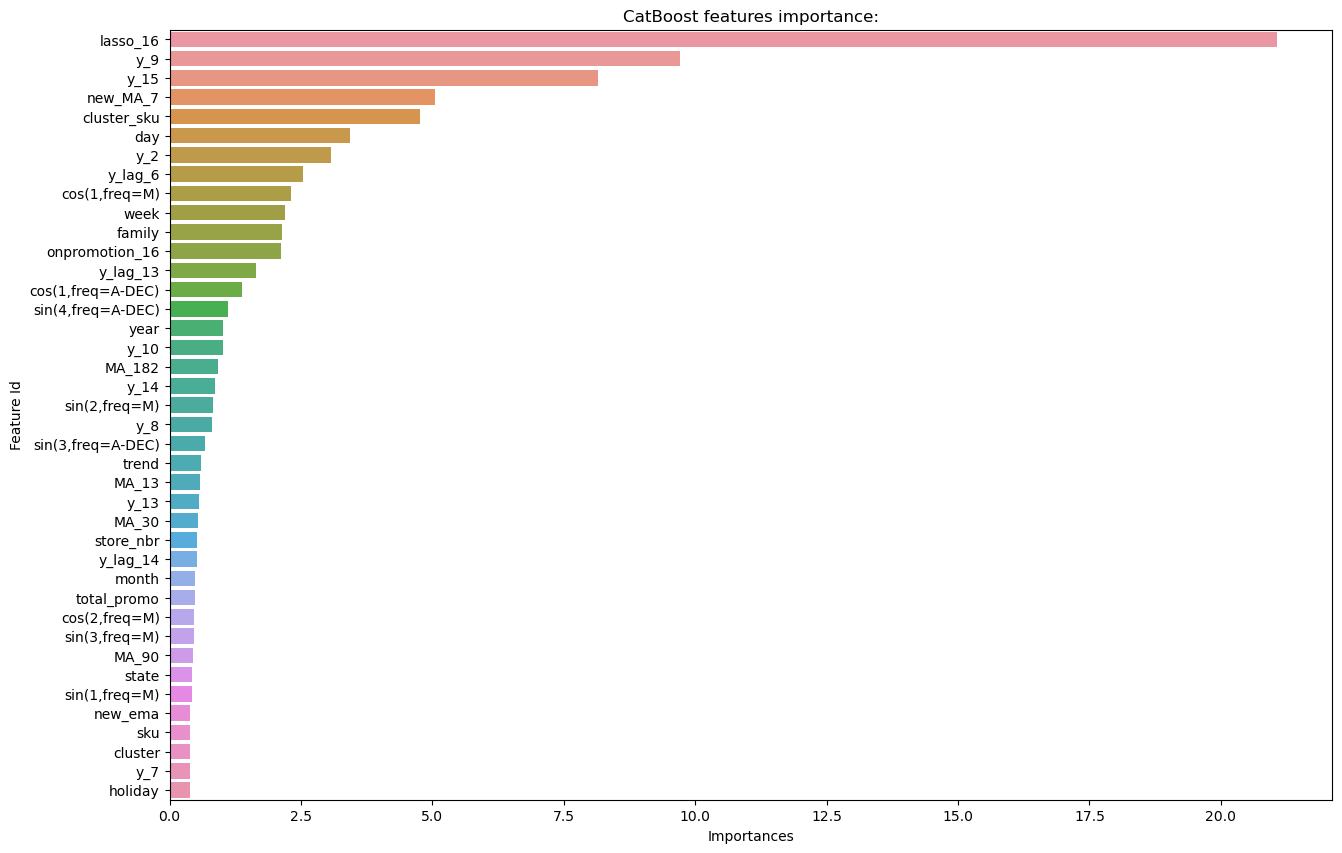

In [99]:
plt.figure(figsize=(15, 10));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df.iloc[:40]);
plt.title('CatBoost features importance:');

In [100]:
subm = pd.read_csv('input_data/sample_submission.csv', index_col=0)

In [101]:
a = pd.DataFrame()
for i in range(16):
    a = pd.concat([a, final.loc[:, f'y_{i+1}']])

In [102]:
a

,0
2017-08-16,1.577080
2017-08-16,0.000000
2017-08-16,1.825580
2017-08-16,7.754945
2017-08-16,0.019677
...,...
2017-08-16,5.914871
2017-08-16,4.589083
2017-08-16,7.180219
2017-08-16,4.506886


In [103]:
subm['sales'] = a[0].values

In [104]:
subm['sales'] = subm['sales'].apply(np.expm1)

In [105]:
subm

,sales
id,
3000888,3.840802
3000889,0.000000
3000890,5.206395
3000891,2332.080585
3000892,0.019872
...,...
3029395,369.506668
3029396,97.404183
3029397,1312.195575


In [106]:
subm.to_csv('28_attempt.csv')

## *Result*

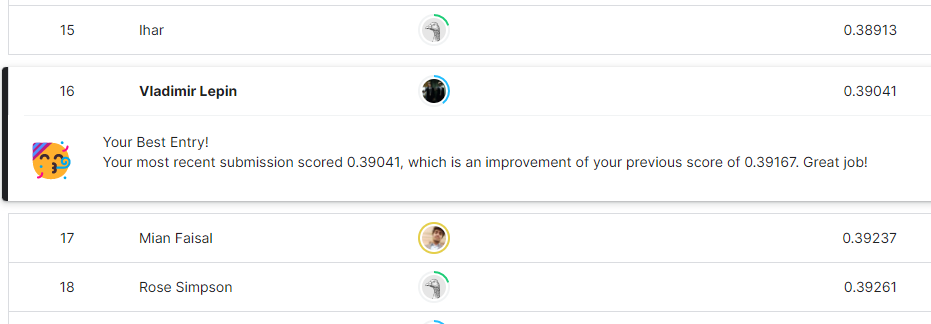|

#### `top 2%`